# Lake model continued - subspace partitioning

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## 1. Apply scenario discovery

1. Instanciate the model and define its parameters. Use the same parameters as in Assignment 2.

In [1]:
from lakemodel_function import lake_problem
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant, ema_logging,
                           perform_experiments, Policy, MultiprocessingEvaluator)
from ema_workbench.analysis import prim
import seaborn as sns

In [2]:
# Step 1: Instantiate the model
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model('LakeModel', function=lake_problem)

# Define the uncertainties based on the provided table
model.uncertainties = [
    RealParameter("mean", 0.01, 0.05),   # renamed from 'mu' to 'mean' for consistency with the lake_model function
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2, 4.5),
    RealParameter("delta", 0.93, 0.99)
]

# Define a list to hold all the lever definitions
model.levers = [
    RealParameter(f"l{i}", 0, 0.1) for i in range(100)
]

model.outcomes = [ScalarOutcome('max_P'), 
                  ScalarOutcome('utility'), 
                  ScalarOutcome('inertia'), 
                  ScalarOutcome('reliability')]

2. Generate 10 policies and 1000 scenarios and evaluate them.

In [4]:
from ema_workbench.em_framework.samplers import LHSSampler  # Correct import statement for LHSSampler

# Step 2: Generate policies and scenarios
scenarios = 1000

# Step 3: Evaluate the policies and scenarios
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=10, uncertainty_sampling=LHSSampler())

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|██████████████████████████████████| 10000/10000 [00:05<00:00, 1869.61it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


3. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop_columns`*

In [5]:
# Step 4: Clean the experiments array
experiments = experiments.drop(columns=[f"l{i}" for i in range(100)])  # Removing decision levers

4. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 871 cases of interest
[MainProcess/INFO] mean: 0.8988095238095238, mass: 0.0504, coverage: 0.5200918484500574, density: 0.8988095238095238 restricted_dimensions: 3


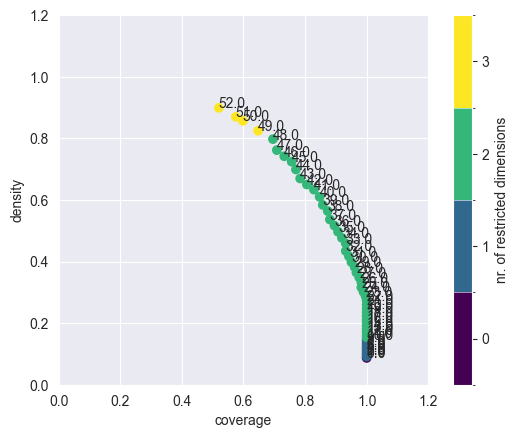

In [6]:
# Step 5: Apply scenario discovery
x = experiments
worst_outcomes = np.percentile(outcomes['reliability'], 10)
y = outcomes['reliability'] < worst_outcomes # Focus on the worst 10% outcomes

prim_alg = prim.Prim(x, y, threshold=0.8)   
box = prim_alg.find_box()

box.show_tradeoff(annotated=True)
plt.show()

In [7]:
box.inspect(10)

coverage       1.000000
density        0.146387
id            10.000000
k            871.000000
mass           0.595000
mean           0.146387
n           5950.000000
res_dim        1.000000
Name: 10, dtype: float64

     box 10                                 
        min       max qp value      qp value
b  0.100301  0.308217      NaN  1.716098e-50


[None]

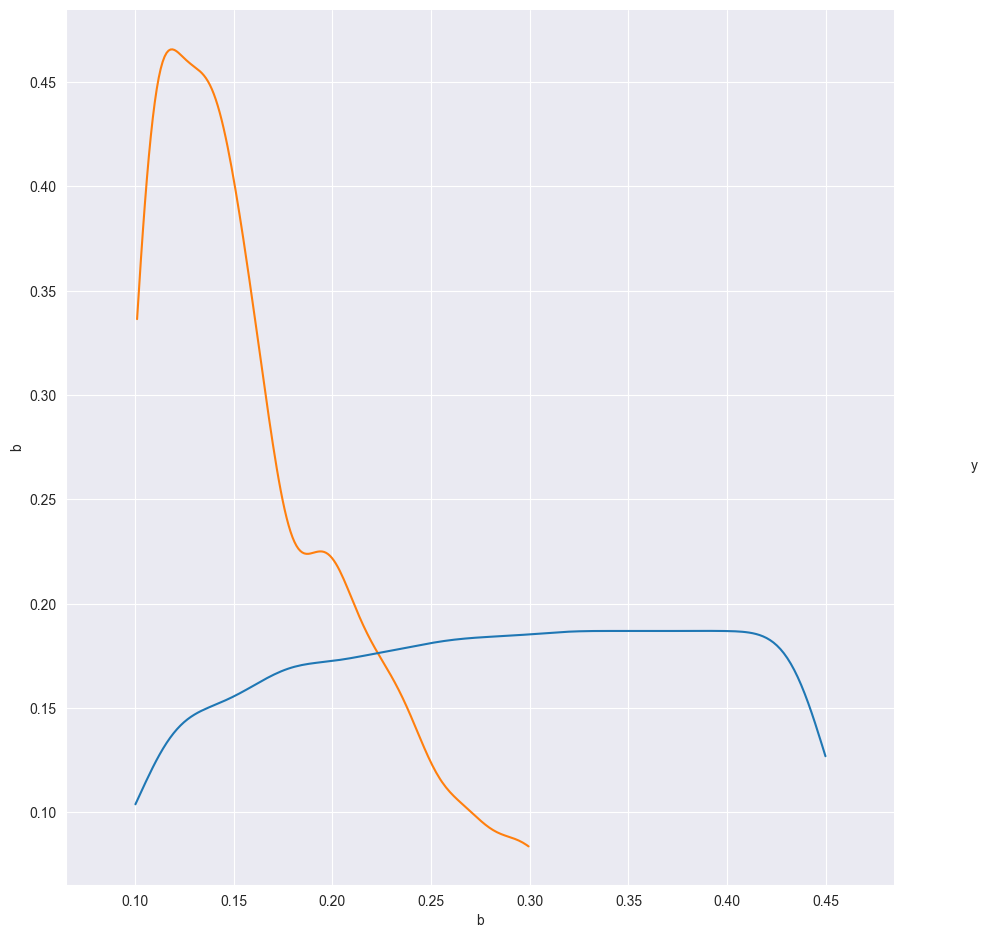

In [8]:
box.select(1)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

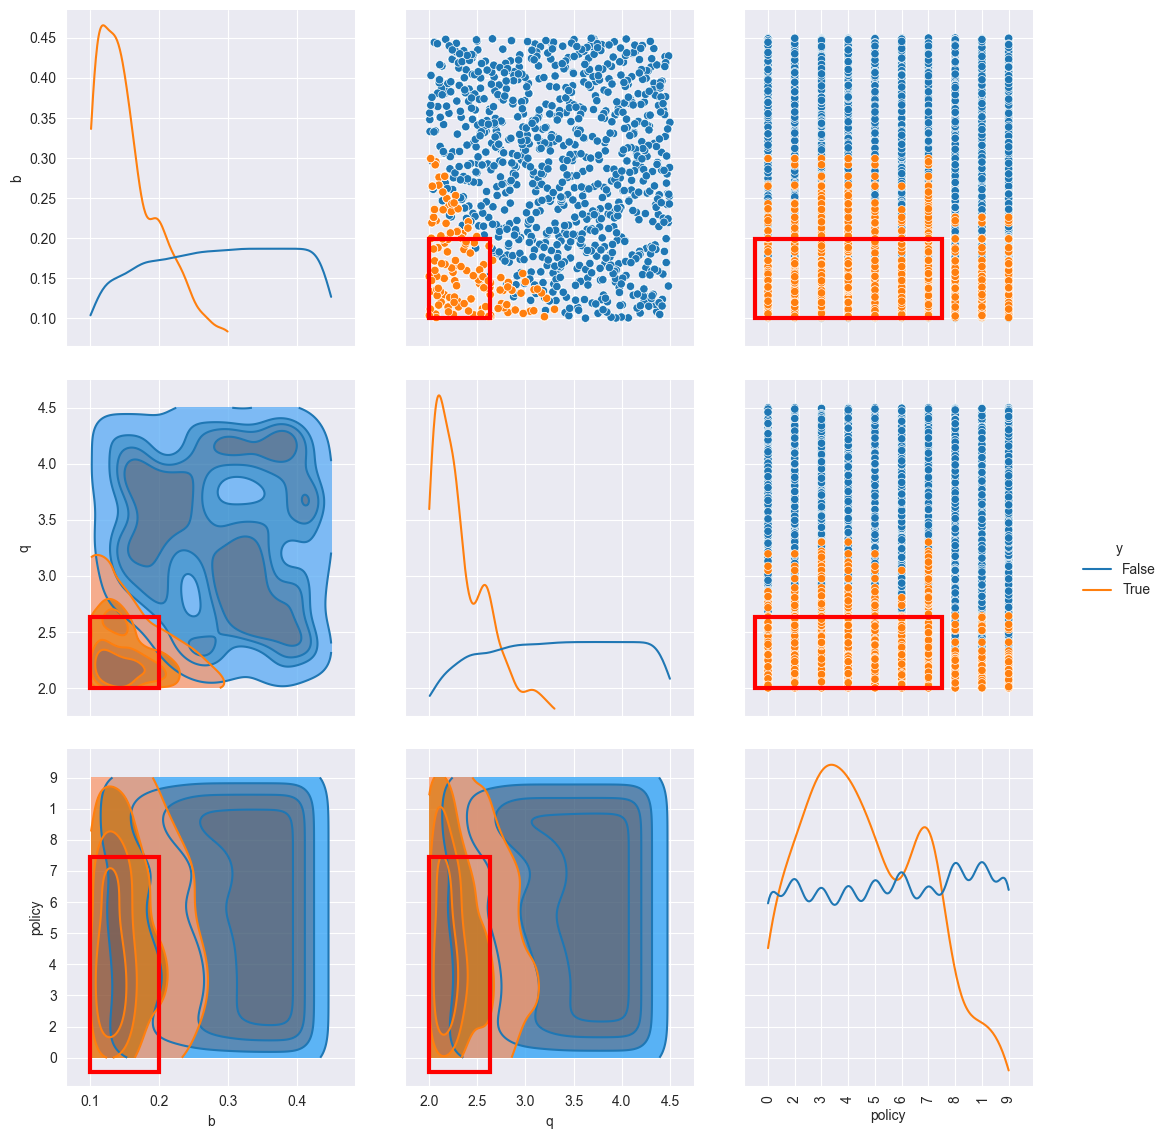

In [9]:
box.select(52)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


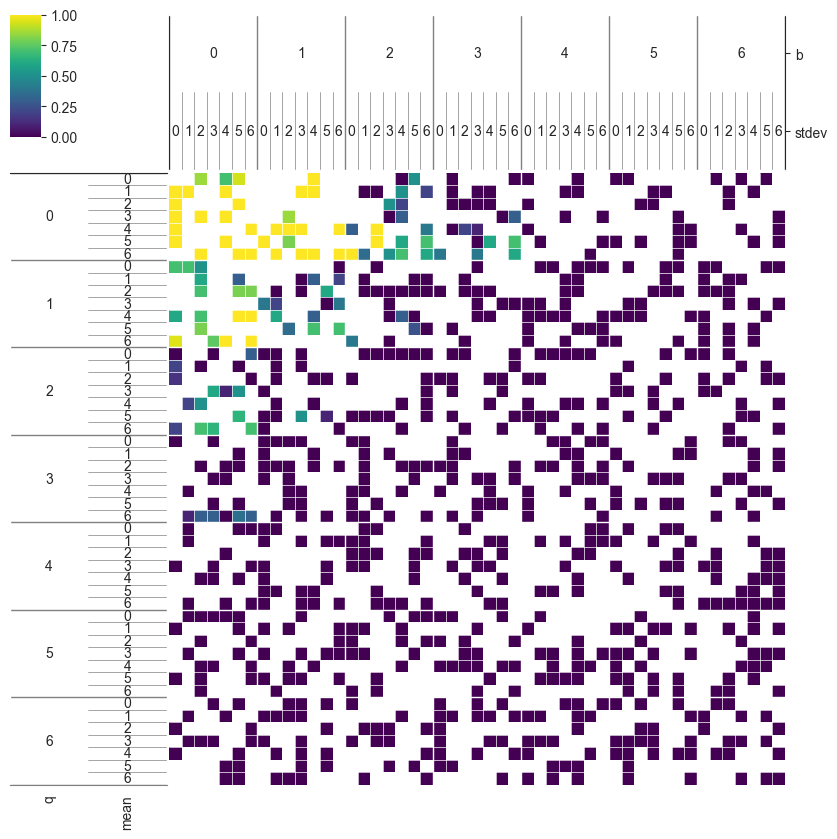

In [11]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=7)
plt.show()

# Distribution of Outcomes

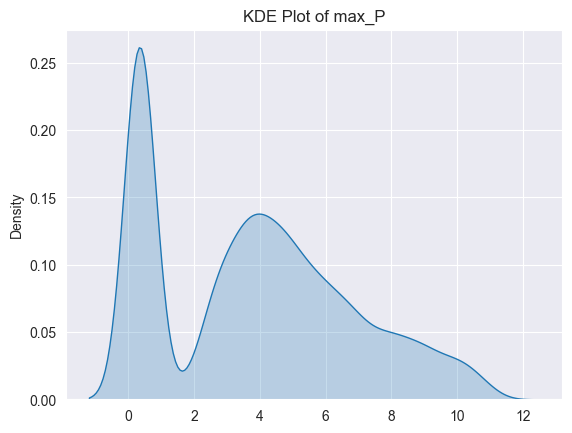

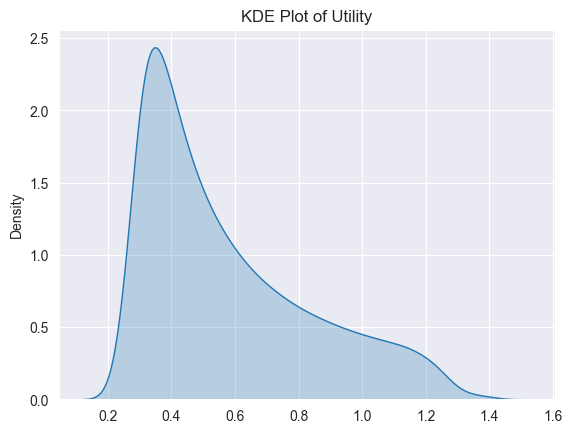

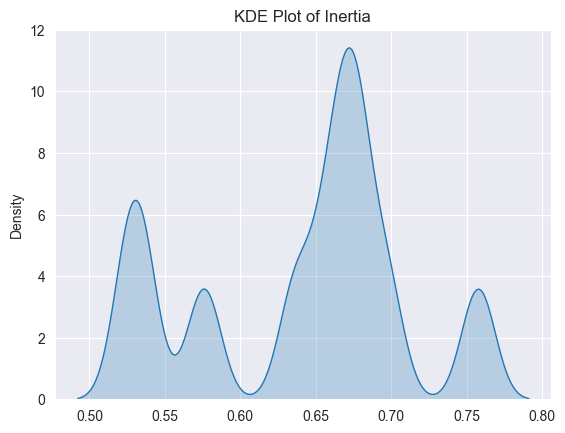

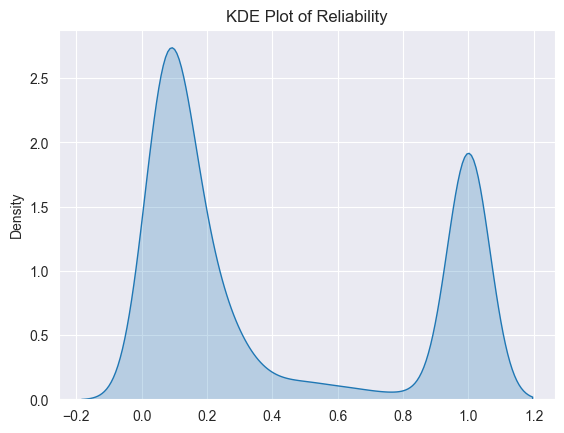

In [13]:
sns.kdeplot(outcomes['max_P'], fill=True)
plt.title('KDE Plot of max_P')
plt.show()

sns.kdeplot(outcomes['utility'], fill=True)
plt.title('KDE Plot of Utility')
plt.show()

sns.kdeplot(outcomes['inertia'], fill=True)
plt.title('KDE Plot of Inertia')
plt.show()

sns.kdeplot(outcomes['reliability'], fill=True)
plt.title('KDE Plot of Reliability')
plt.show()